In [1]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path
sns.set(font_scale=1.8, style="ticks")

/data/rbg/users/wxsh/miniconda3/envs/vaxseer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runs_folder = Path("../../../runs/cov_continents")
data_folder = Path("../../../data/gisaid/cov/spike_rbd_processed_continents")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

# NLL & revNLL

In [3]:
testing_window=3
year_and_month_all = ("2021-07", "2021-10", "2022-01", "2022-04")
locations = ("africa", "asia", "europe", "north_america", "oceania", "south_america")


def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    
    if "token_num" in df:
        token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
        token_num = torch.mean(token_num.float(), dim=1)
        nll = torch.sum(freqs * nlls) / torch.sum(freqs * token_num)
    else:
        nll = torch.sum(freqs * nlls)
    
    return nll


def read_all_nll(path, id2location):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print(path)
            return None
        
        df = pd.read_csv(path)
        locations = []
        counts = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
            counts.append(id2count[src_id])
        df["location"] = locations
    #     df["freq"] = counts / sum(counts)
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)
        
time2location_to_count = dict()
id2location = dict()
id2count = defaultdict(int)

for year_and_month in year_and_month_all:
    year, month = year_and_month.split("-")
    year = int(year)
    
    testing_index = int((year - 2020) * 12 / testing_window + (int(month) + testing_window - 1) / testing_window)
    
    total_bin_size=0
    data_bin_size=0
    location_to_count = defaultdict(int)

    all_test_path=data_folder / f"2020-01_to_2023-12_{testing_window}M/all/human_minBinSize100_minLen223_maxLen223_location_region1_bins/{testing_index}.fasta"
    bin_size=int(next(SeqIO.parse(all_test_path, "fasta")).description.split("bin_size=")[1].split("|")[0])
    data_bin_size+=bin_size

    for record in SeqIO.parse(all_test_path, "fasta"):
        desc = record.description.split()[1].split("|")
        desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
        id2location[record.id] = desc["location"]
        id2count[record.id] += round(float(desc["freq"]) * int(desc["bin_size"]))

        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))

    print("Total number of seqs:", sum(id2count.values()), data_bin_size, sum(location_to_count.values()))
    
    time2location_to_count[year_and_month] = location_to_count


Total number of seqs: 2630701 2630701 2630701
Total number of seqs: 5737917 3107216 3107216
Total number of seqs: 7270986 1533069 1533069
Total number of seqs: 8606214 1335228 1335228


In [4]:
nll_results = defaultdict(list)

for year_and_month in year_and_month_all:
    print(year_and_month)
    year, month = year_and_month.split("-")
    year = int(year)

    for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
        name2nll_path = {
                "Global": runs_folder / f"2019-12_to_{year_and_month}_1M/global/test_{testing_window}M/temp_{temperature}/test_results.csv",
                "Prepend": runs_folder / f"2019-12_to_{year_and_month}_1M/prepend/test_{testing_window}M/temp_{temperature}/test_results.csv",
                "Add_Embed": runs_folder / f"2019-12_to_{year_and_month}_1M/concat/test_{testing_window}M/temp_{temperature}/test_results.csv",
                "Param_share": runs_folder / f"2019-12_to_{year_and_month}_1M/param_share/test_{testing_window}M/temp_{temperature}/test_results.csv",
                "LoRA": {
                    location: (runs_folder / f"2019-12_to_{year_and_month}_1M/finetune_lora/test_{testing_window}M/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv") for location in locations
                },
                "Finetune": {
                    location: (runs_folder / f"2019-12_to_{year_and_month}_1M/finetune/test_{testing_window}M/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv") for location in locations
                },
                "Transmission": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission/test_{testing_window}M/temp_{temperature}/lightning_logs/version_0/test_results.csv"   
            }
        model2nll = dict()
        for model in name2nll_path:
            model2nll[model] = read_all_nll(name2nll_path[model], id2location)

        for location in locations:
            for rev_nll_dir in ("test_rev_1", "test_rev_2", "test_rev_3"):

                name2rev_nll_path = {                    
                    "Transmission": runs_folder / f"2019-12_to_{year_and_month}_1M/transmission/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Add_Embed": runs_folder / f"2019-12_to_{year_and_month}_1M/concat/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Prepend": runs_folder / f"2019-12_to_{year_and_month}_1M/prepend/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Global": runs_folder / f"2019-12_to_{year_and_month}_1M/global/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "LoRA": runs_folder / f"2019-12_to_{year_and_month}_1M/finetune_lora/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Finetune": runs_folder / f"2019-12_to_{year_and_month}_1M/finetune/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Param_share": runs_folder / f"2019-12_to_{year_and_month}_1M/param_share/{rev_nll_dir}/{location}/temp_{temperature}/lightning_logs/version_0/test_results.csv"
                }

                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name] # os.path.join(_path, "test_rev/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (continent, temperature))

                    if os.path.exists(our_model_path_rev_nll) and name in model2nll:
                        df = model2nll[name]
                        nll = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["time"].append(year_and_month)
                        nll_results["bin_size"].append(time2location_to_count[year_and_month][location])
                        nll_results["oracle_model"].append(rev_nll_dir)

                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print(our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

nll_results = pd.DataFrame(nll_results)
print(nll_results)


2021-07
2021-10
2022-01
2022-04
           NLL  reverse NLL  temperature       location         model  \
0     0.187725     0.028406          0.2         africa        Global   
1     0.205735     0.012555          0.2         africa       Prepend   
2     0.202560     0.012774          0.2         africa     Add_Embed   
3     0.174999     0.008169          0.2         africa   Param_share   
4     0.187744     0.028588          0.2         africa          LoRA   
...        ...          ...          ...            ...           ...   
2515  0.046538     0.025676          1.0  south_america     Add_Embed   
2516  0.053134     0.030713          1.0  south_america   Param_share   
2517  0.057024     0.029448          1.0  south_america          LoRA   
2518  0.059776     0.025422          1.0  south_america      Finetune   
2519  0.051576     0.030317          1.0  south_america  Transmission   

         time  bin_size oracle_model  
0     2021-07     25760   test_rev_1  
1     2021-07

In [5]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df["NLL"]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df["reverse NLL"]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df["NLL"])
            ave_rev_nll = np.mean(_df["reverse NLL"])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results["nll"].append(ave_nll)
        summary_nll_results["rev_nll"].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [6]:
def plot(summary_summary_df, fig_title, fig_save_path):
    plt.xscale('log')
    plt.yscale('log')

    plt.rcParams['lines.markersize'] = 15
    
    ori_our_model_name = "Transmission"
    our_model_name = r'$\bf{Transmission}$' # r'$\bf{Bold}$'
    
    summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]

    models = list(set(summary_summary_df["model"]))
    models.sort()
    style_dict = {}
    for model in models:
        if model == our_model_name:
            style_dict[model] = ""
        else:
            style_dict[model] = (2,2)

    style_order = models
    style_order.remove(our_model_name)
    style_order = [our_model_name] + style_order
    style_order =  [our_model_name, 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']
    palette_light = sns.color_palette("Set2", n_colors=8) # pastel
    palette_dark = sns.color_palette("hls", n_colors=8)
    color_dict = {}
    for i, model in enumerate(models):
        color_dict[model] = palette_light[i]
    color_dict[our_model_name] = palette_dark[5]    
    ax = sns.lineplot(summary_summary_df, x="nll", y="rev_nll", hue="model", markers=True,
                      sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order)
    
    ax.set_title(fig_title)    
    ax.set_xlabel("NLL")
    ax.set_ylabel("reverse NLL")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig(fig_save_path, format='pdf', bbox_inches='tight')
    plt.show()

africa 72208


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


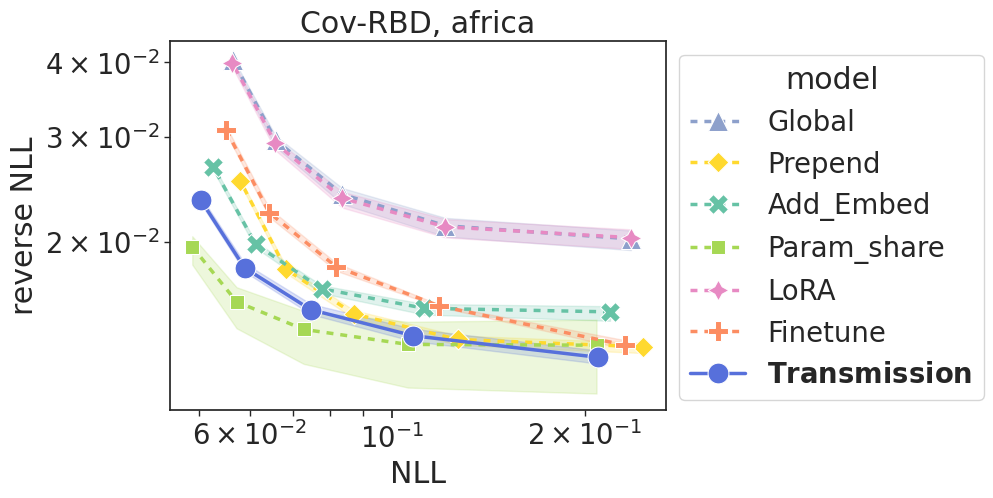

oceania 146961


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


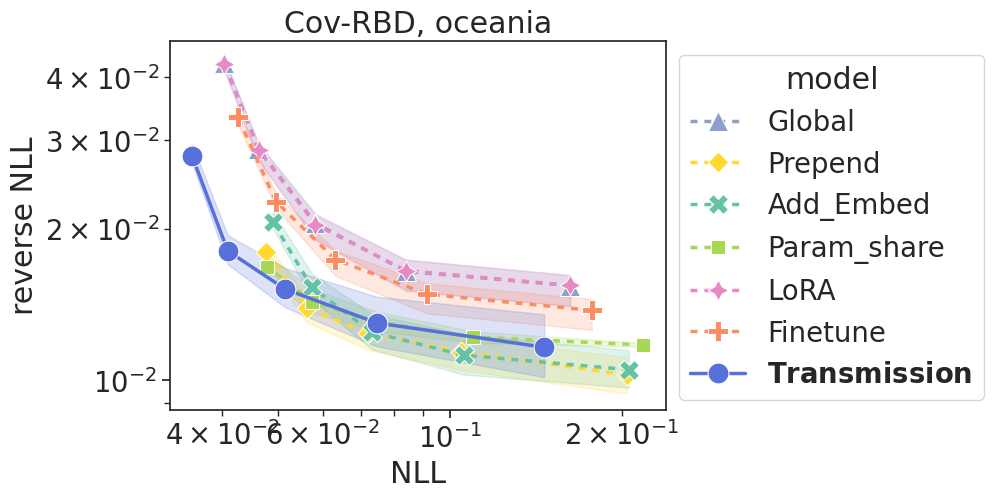

south_america 206656


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


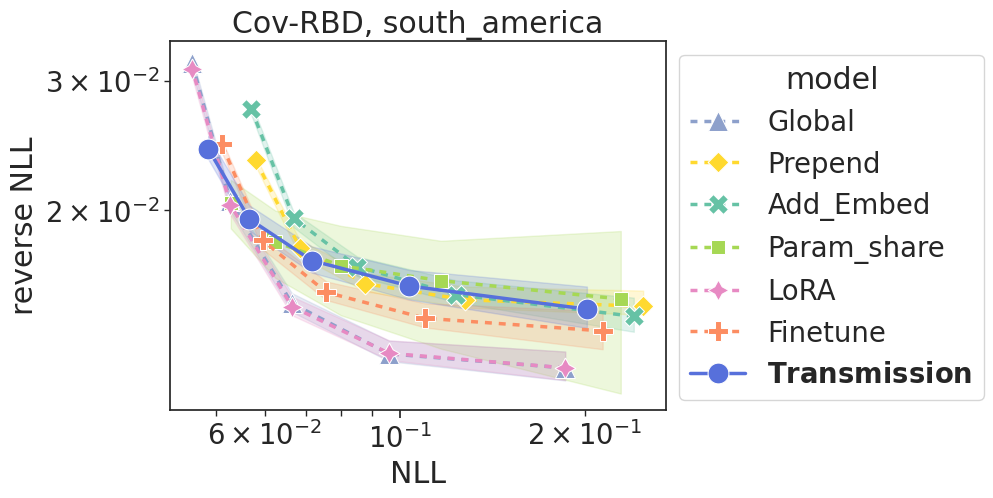

asia 766656


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


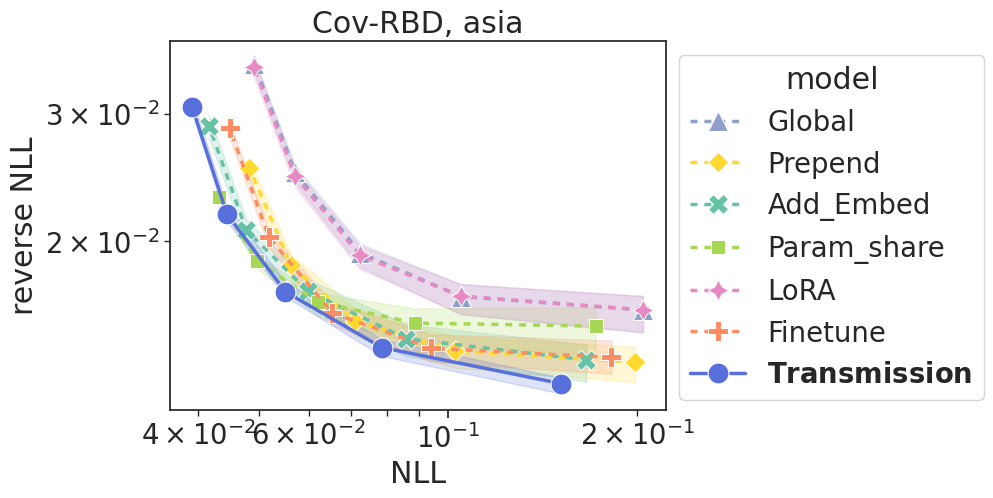

north_america 2951285


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


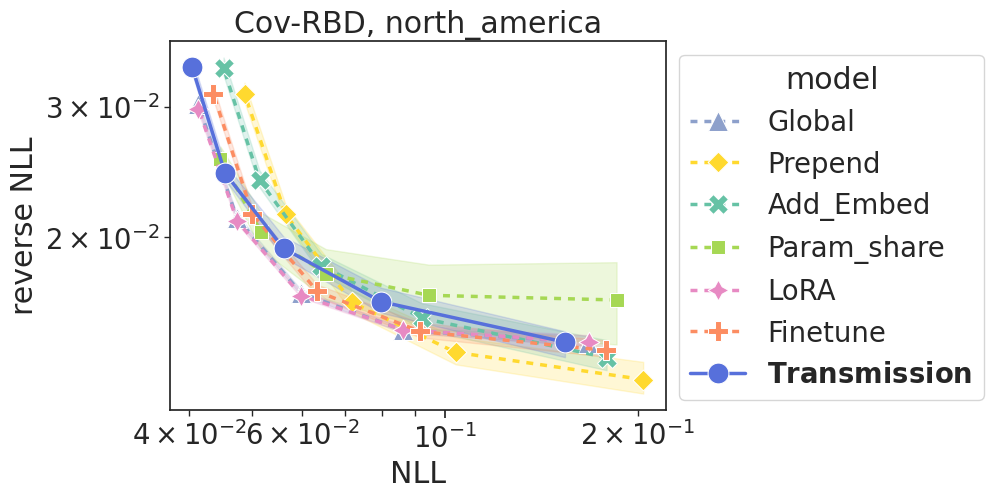

europe 4462448


/tmp/ipykernel_482384/1047969874.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [x if x != ori_our_model_name else our_model_name for x in summary_summary_df["model"]]


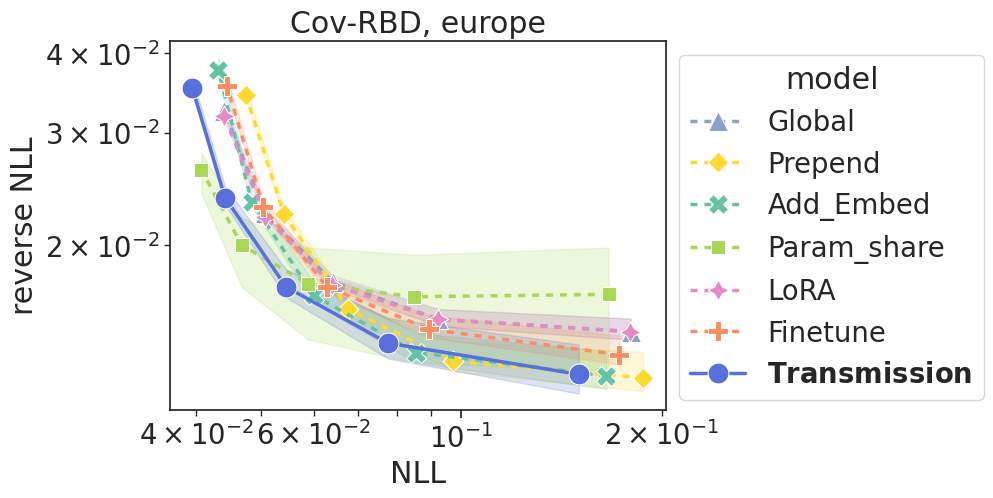

In [7]:
local_summary_df = get_summary(nll_results, keys=("model", "temperature", "location", "oracle_model"))

sorted_locations = sorted(dict(zip(local_summary_df["location"], local_summary_df["toal_sample_size"])).items(), key=lambda x: x[1])

for location, ss in sorted_locations:
    print(location, ss)
    local_df = local_summary_df[local_summary_df["location"] == location]
    if len(local_df) <= 0:
        continue
    
    plot(local_df, "Cov-RBD, %s" % (location), 
         saving_dir / f"cov_continent_{location}.pdf")
    

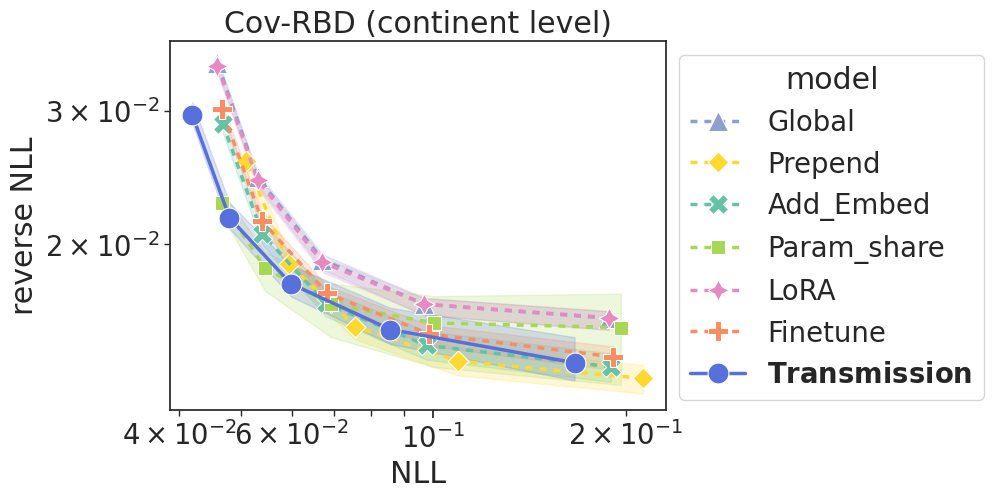

In [8]:
summary_summary_df = get_summary(nll_results[nll_results["bin_size"] >= 200], keys=("model", "temperature", "oracle_model"), weighted_average=False)
plot(summary_summary_df, "Cov-RBD (continent level)", 
         saving_dir / "main_res_cov_continent_average.pdf")

In [10]:
def calculate_ci(data):
    # Calculate sample mean and standard deviation
    assert len(data) == 3
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)

    # Calculate the 95% confidence interval
    confidence = 0.95
    alpha = 1 - confidence

    # For large samples, use z-distribution
    z_critical = stats.norm.ppf(1 - alpha / 2)

    # For small samples, use t-distribution
#     t_critical = stats.t.ppf(1 - alpha / 2, df=n-1) # Uncomment for small samples

    # Margin of error
    margin_of_error = z_critical * (std_dev / np.sqrt(n))
#     margin_of_error = t_critical * (std_dev / np.sqrt(n)) # Uncomment for small samples

    # Confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return mean, ci_lower, ci_upper
    

def print_markdown_table(df, temp, group_by=("model",), values=("rev_nll", 'nll')):
    res_dict = dict()
    for i, row in df.iterrows():
        key = tuple(row[x] for x in group_by)
        if key not in res_dict:
            res_dict[key] = defaultdict(list)
        for value in values:
            res_dict[key][value].append(row[value])    
    
    new_table = []
    rev_nll_cis = dict()
    for key in res_dict:
        ci = calculate_ci(res_dict[key]["rev_nll"])
        new_table.append(
            { 'model': key[0], 'nll': res_dict[key]["nll"][0], "rev_nll": ci[0], 'ci_lower': ci[1], 'ci_upper': ci[2]}
        )
        model_name = key[0].replace('_', '\\_')
        if model_name == "Transmission":
            model_name = "{\\bf Transmission}"
        x = f"{model_name} & {temperature} &  {res_dict[key]['nll'][0]:.4f} & {ci[0]:.4f} ({ci[1]:.4f}, {ci[2]:.4f}) \\\\"
        print(x)
        # print(key + " & " + res_dict[key]["NLL"][0] + " & " + "reverse NLL": ci[0] + " & " + "(%.3d)")
    
    
    df = pd.DataFrame(new_table)        
    
    return res_dict, rev_nll_cis

for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
    _, table = print_markdown_table(summary_summary_df[summary_summary_df["temperature"] == temperature], temperature)
    print("\midrule")

Global & 0.2 &  0.1880 & 0.0160 (0.0154, 0.0165) \\
Prepend & 0.2 &  0.2128 & 0.0133 (0.0126, 0.0140) \\
Add\_Embed & 0.2 &  0.1895 & 0.0138 (0.0131, 0.0145) \\
Param\_share & 0.2 &  0.1964 & 0.0156 (0.0131, 0.0182) \\
LoRA & 0.2 &  0.1880 & 0.0160 (0.0154, 0.0166) \\
Finetune & 0.2 &  0.1911 & 0.0142 (0.0136, 0.0148) \\
$\bf{Transmission}$ & 0.2 &  0.1663 & 0.0140 (0.0129, 0.0151) \\
\midrule
Global & 0.4 &  0.0968 & 0.0167 (0.0161, 0.0172) \\
Prepend & 0.4 &  0.1093 & 0.0140 (0.0134, 0.0147) \\
Add\_Embed & 0.4 &  0.0976 & 0.0147 (0.0140, 0.0154) \\
Param\_share & 0.4 &  0.1002 & 0.0158 (0.0138, 0.0178) \\
LoRA & 0.4 &  0.0967 & 0.0167 (0.0161, 0.0172) \\
Finetune & 0.4 &  0.0984 & 0.0152 (0.0147, 0.0158) \\
$\bf{Transmission}$ & 0.4 &  0.0857 & 0.0154 (0.0144, 0.0165) \\
\midrule
Global & 0.6 &  0.0670 & 0.0191 (0.0185, 0.0196) \\
Prepend & 0.6 &  0.0755 & 0.0156 (0.0149, 0.0162) \\
Add\_Embed & 0.6 &  0.0679 & 0.0167 (0.0160, 0.0175) \\
Param\_share & 0.6 &  0.0691 & 0.0167 (0.0151

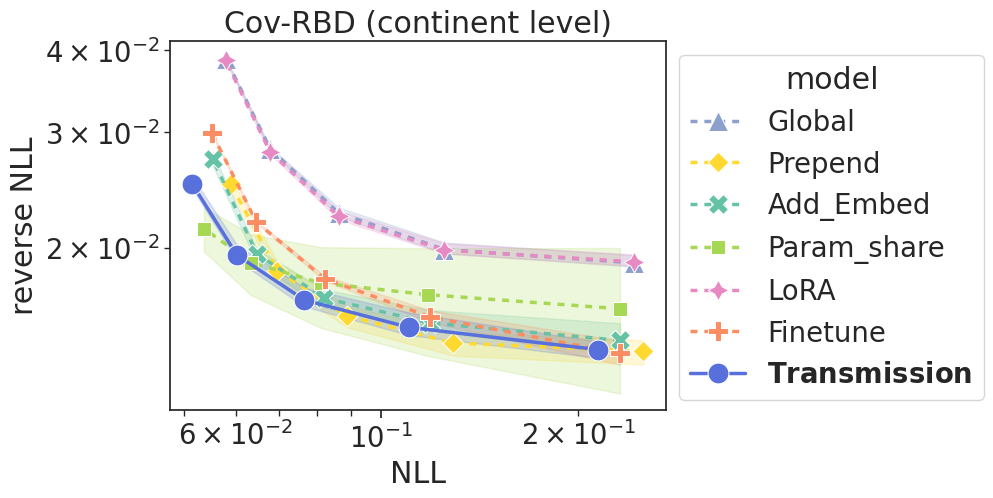

In [11]:
summary_summary_df = get_summary(nll_results[nll_results["bin_size"] >= 200], 
                                 keys=("model", "temperature", "oracle_model", "location"), weighted_average=False)

def get_worset_location(df, key="nll", temp=1.0):
    _df = df[df["temperature"] == temp]
    loc2nlls = defaultdict(list)

    for loc, nll in zip(_df["location"], _df["nll"]):
        loc2nlls[loc].append(nll)

    for loc in loc2nlls:
        assert len(loc2nlls[loc]) == 3

    loc2nlls = {k: np.mean(v) for k, v in loc2nlls.items()}

    return sorted(loc2nlls.items(), key=lambda x: x[1], reverse=True)[0]
    

new_df = []
for model in ['Global', 'Prepend', 'Add_Embed', 'Param_share', 'LoRA', 'Finetune', 'Transmission']:
    _df = summary_summary_df[summary_summary_df["model"] == model]
    location = get_worset_location(_df)[0]
    _df = _df[_df["location"] == location]
    new_df.append(_df)

new_df = pd.concat(new_df)

plot(new_df, "Cov-RBD (continent level)", 
         saving_dir / "main_res_cov_continent_worse.pdf")